# Анализ поведения игроков и  рекламных источников мобильной игры «Космические братья»

<div class="alert alert-info">
<h2> Привет!<a class="tocSkip"></h2>
<hr>  
Я - Сергей. Рад что ты читаешь это текст :) Сделаю пару ремарок общего характера. В описании выполняемых действий, комментариях, я использую местоимение 'мы', так как считаю что ты - ревьювер, проверя код становиться моим соучастником ('соучавствующие программирование') и мы вместе проходим по пути исследования. Да и сформировлась привычка так писать в ходе написания научных работ.   
NB! - так помечаю важные на мой взгдял идеи, которые стоит взять на заметку; инсайты, проработка которых требует большего знания предметной области.   
Надеюсь мои многословные комментарии тебя не утомят.    
    
</div>
    
<br/>

**Содержание**  
[0. ссылка на презентацию](#)   
https://drive.google.com/file/d/1gJGtxkvnexsmeUMVc34okVTSLGvNFF7i/view?usp=sharing     
[1. Описание проекта](#description)   
[2. Загрузка и изучение данных](#review)   
[3. Предобработка данных](#preparing)  
[4. Анализ данных](#analysis)   
[4.1. Исследовательский анализ данных (EDA)](#EDA)   
[4.2. Анализ активности игроков](#users)   
[4.3. Анализ рекламной активности](#ad)   
[4.4. Анализ влияния источника перехода в игру на поведение пользователей](#traffic)   
[5. Проверка гипотез](#hypotheses)   
[6. Выводы и рекомендации](#summary)     

---

## Описание проекта<a id="description"></a>      
Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.   
    
Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.    
    
В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:   
* Победа над первым врагом   
* Реализация проекта - разработка орбитальной сборки спутников   
   
В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.   
   
**Описание датасетов**    
1. Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

2. Датасет *ad_cost.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

3. Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
from io import BytesIO
import requests
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st

---

## Загрузка и изучение данных <a id="review"></a>   
* Загрузим данные с гугл диска   
* Изучим данные - посмотрим стиль заголовков колонок, проверим соответствие содаржания колонок их типам данных, проверим их на наличие пропусков и дубликатов  

In [2]:
# Загрузим данные с гуглдиска
spreadsheet_ad_costs = '1JGr6L2JeG7Pxz-8w3ZmEmRnk0u_BxiyczA_2cmlt9_w'
spreadsheet_game_actions = '17eI9CLX_hFnXjHG1-2CBJu0IXVO9WQ5NAI2dKjHDCMM'
spreadsheet_user_source = '10oRDhQyPhCnYzerRFbYVSPhIBAzIAUBp_HA65sP5vZc'
file_name_ad_costs = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_ad_costs)
file_name_game_actions = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_game_actions)
file_name_user_source = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_user_source)
r_ad_costs = requests.get(file_name_ad_costs)
r_game_actions = requests.get(file_name_game_actions)
r_user_source = requests.get(file_name_user_source)
ad_costs = pd.read_csv(BytesIO(r_ad_costs.content)) # Датасет с источниками рекламного трафика
game_actions = pd.read_csv(BytesIO(r_game_actions.content)) # Датасет с активностями игроков
user_source = pd.read_csv(BytesIO(r_user_source.content)) # Датасет с источниками откуда пришли пользователи

In [3]:
# Посмотрим на датафрейм ad_costs
display(ad_costs.head()) # Выведем 5 верхних записей
print('-------------------------------------')
print('Описание датасета')
ad_costs.info() # Посмотрим описание датафрейма
print('-------------------------------------')
print('Пропуски данных')
ad_costs.isna().sum() # Проверим пропуски

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


-------------------------------------
Описание датасета
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
-------------------------------------
Пропуски данных


source    0
day       0
cost      0
dtype: int64

In [4]:
# Проверим дублирующиеся записи
print('Дубликаты')
ad_costs.duplicated().sum()

Дубликаты


0

В датафреме ad_costs 28 записей (строк) и три колонки. Имена колонок соответствуют хорошему стилю написания. Пропусков данных и дубликатов - нет. Тип данных колонки day, хранящей дату, не соответвует её содержимому - приведём её к типу date.

In [5]:
# Посмотрим на датафрейм game_actions
display(game_actions.head()) # Выведем 5 верхних записей
print('-------------------------------------')
print('Описание датасета')
game_actions.info() # Посмотрим описание датафрейма
print('-------------------------------------')
print('Пропуски данных')
game_actions.isna().sum() # Проверим пропуски

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 0:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 0:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 0:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 0:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 0:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


-------------------------------------
Описание датасета
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
-------------------------------------
Пропуски данных


event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

In [6]:
# Проверим дублирующиеся записи
print('Дубликаты')
game_actions.duplicated().sum()

Дубликаты


1

В датафреме game_actions 135640 записей (строк) и пять колонок. Имена колонок соответствуют хорошему стилю написания. В датафреме есть пропуски данных в колонках building_type (пропущено 7683 записей) и project_type (пропущено 133774 записей, т.е. большинство). Тип данных колонки event_datetime, хранящей дату и время события, не соответвует её содержимому - приведём её к типу date.

In [7]:
# Посмотрим на датафрейм user_source
display(user_source.head()) # Выведем 5 верхних записей
print('-------------------------------------')
print('Описание датасета')
user_source.info() # Посмотрим описание датафрейма
print('-------------------------------------')
print('Пропуски данных')
user_source.isna().sum() # Проверим пропуски

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


-------------------------------------
Описание датасета
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
-------------------------------------
Пропуски данных


user_id    0
source     0
dtype: int64

In [8]:
# Проверим дублирующиеся записи
print('Дубликаты')
user_source.duplicated().sum()

Дубликаты


0

В датафреме user_source 13576  записей (строк) и две колонки. Имена колонок соответствуют хорошему стилю написания. Пропусков данных и дубликатов - нет. Тип данных колонок соответсвуют их содержанию.
   
**Вывод**   
В датафремах есть попущенные значений, дубликат и неправильные типы у данных - исправим эти проблемы.

---

## Предобработка данных <a id="preparing"></a>    
* Обработаем пропуски данных в датафреме game_actions   
* Удалим дубликат из датафрема game_actions   
* Приведём содержание колонок датафреймов ad_costs и game_actions с датами и временем к типу данных date  

**Обработаем пропуски данных колонки project_type датафрема game_actions**

In [9]:
# Посмотрим какие есть значения в колонке project_type
game_actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

В колонке два значений nan - то есть пропуск, и satellite_orbital_assembly - исследование спутника. Нет данных игроков о победе (дошли до конца уровня) или пройгрыше (не дошли до конца уровня).   
Поэтому мы заполним пропуски пользователей, завершивших уровень, как победу (finished_stage_1), а пропуски не завершивших уровень, как не достигидение победы (not_finished_stage_1).

In [10]:
# Заполним пропуски
# дошедшых до конца игроков
game_actions.loc[game_actions['project_type'].isna() &
                 (game_actions['event'] == 'finished_stage_1'),
                 'project_type'] = 'finished_stage_1'             
# не дошедших до конца игроков
game_actions.loc[game_actions['project_type'].isna(), 'project_type'] = 'not_finished_stage_1'

Обработаем пропуски данных колонки building_type датафрема game_actions

In [11]:
# Посмотрим какие есть значения в колонке building_type
game_actions['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

В колонке есть все задокументированные типы построек и пропуски, т.е. заменить "в лоб" не получится. Возможно пропуски связаны с каким-то другим атрибутом игроков и их действий. Посмотрим только на записи с пропусками.

In [12]:
# Вывидем записи с пропусками
game_actions[game_actions['building_type'].isna()]

,event_datetime,event,building_type,user_id,project_type
6659,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1
13134,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,finished_stage_1
15274,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,finished_stage_1
16284,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,finished_stage_1
19650,2020-05-06 6:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,finished_stage_1
...,...,...,...,...,...
135632,2020-06-04 15:50:38,finished_stage_1,NaN,22cce310-fe10-41a2-941b-9c3d63327fea,finished_stage_1
135633,2020-06-04 17:56:14,finished_stage_1,NaN,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,finished_stage_1
135636,2020-06-05 2:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,finished_stage_1
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,finished_stage_1


Видно что замешана колонка с типом события - event. Проверим связь типа события и пропусков.

In [13]:
game_actions[game_actions['building_type'].isna()]['event'].unique()

array(['finished_stage_1', 'project'], dtype=object)

Пропуски в колонке building_type у игроков завершивших уровень или проект - видимо уровень/ проект можно завершить не возводя постройки. Поэтому заменим пропуски на отсутвие построек (no_buildings)

In [14]:
# Заполняем пропуски в колонке building_type
game_actions['building_type'] = game_actions['building_type'].fillna('no_buildings')

In [15]:
# Посмотрим что получилось
display(game_actions.head())
print('--------------------')
# Проверим пропуски
print('Пропуски данных')
game_actions.isna().sum()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 0:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,not_finished_stage_1
1,2020-05-04 0:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,not_finished_stage_1
2,2020-05-04 0:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,not_finished_stage_1
3,2020-05-04 0:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,not_finished_stage_1
4,2020-05-04 0:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,not_finished_stage_1


--------------------
Пропуски данных


event_datetime    0
event             0
building_type     0
user_id           0
project_type      0
dtype: int64

**Удалим дубликат из датафрема game_actions**

In [16]:
# Посмотрим на строку-дубликат
game_actions[game_actions.duplicated()]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,not_finished_stage_1


In [17]:
# Удалим строку дубликат
game_actions = game_actions.drop_duplicates()
# Проверим дублирующиеся записи
print('Дубликаты')
game_actions.duplicated().sum()

Дубликаты


0

**Приведём содержание колонок датафреймов ad_costs и game_actions с датами к типу данных date**

In [18]:
# Приведём колонки к типу данных date
ad_costs['day'] = pd.to_datetime(ad_costs['day'])
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
#ad_costs.info()
#game_actions.info()

**Вывод**  
Мы обработали пропуски, удалили дубликат и исправили типы данных в датафремах. Можно преходить к анализу данных.

---

## Анализ данных<a id="analysisanalysis"></a>   
Мы проведём:   
* Исследовательский анализ данных (EDA)   
* Анализ активности игроков    
* Анализ рекламной активности     
* Анализ влияния источника перехода в игру на поведение пользователей   



### Исследовательский анализ данных (EDA)<a id="EDA"></a>    
* Обзор данных (методом .describe(), построение гистограмм)   
* Поиск и исправление аномальных значений в данных (выбросов)  

In [19]:
# Посмотрим описательную статистику по датафрему ad_costs
ad_costs.describe()

,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


Средняя ценка клика - 271,56 у.е., минимальная - 23,31 у.е., максимальная - 969,13 у.е. (возможно это аномалия), медианная - 160,06 у.е.

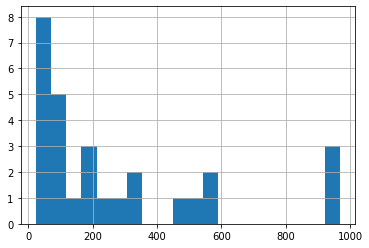

In [20]:
# Построим гистограмму с распределением данных в колонке cost
hist = ad_costs['cost'].hist(bins=20)

Большинство наблюдений сконцентрированно вокруг минимального значений, но максимальное значение это не аномалия, не ошибка, т.к. оно не одно - это реальная стоимоть клика.

In [21]:
game_actions.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,event_datetime,event,building_type,user_id,project_type
count,135639,135639,135639,135639,135639
unique,128790,3,4,13576,3
top,2020-05-09 21:49:07,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,not_finished_stage_1
freq,4,127956,59325,22,127956
first,2020-05-04 00:00:01,NaN,NaN,NaN,NaN
last,2020-06-05 12:32:49,NaN,NaN,NaN,NaN


Самое популярное строение - spaceport. Посмотрим на распределение событий во времени.

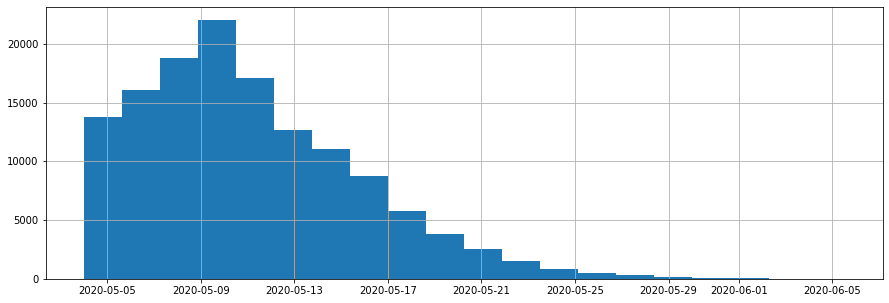

In [22]:
# Построим гистограмму с распределением данных в колонке event_datetime
hist = game_actions['event_datetime'].hist(figsize=(15,5), bins=20)

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>⛅️ 

Хотелось бы более богатого оформления графиков, подписи осей, заголовок бы добавить 
</div>

В начале периода большое количество событий, но потом длинный хвост - интерес игроков падает.

In [23]:
user_source.describe()

,user_id,source
count,13576,13576
unique,13576,4
top,0001f83c-c6ac-4621-b7f0-8a28b283ac30,yandex_direct
freq,1,4817


Больше всего игроков приходят через yandex_direct  
   
**Вывод**  
Явных аномалий в датафремах нет.   

### Анализ активности игроков<a id="users"></a>    
Мы проанализируем:   
* Количество пользователей за весь период   
* Количество событий за весь период    
* Количество игроков завершивших 1 уровень игры   
* Количество построеных игроками объектов за весь период  
* Число объектов на одного игрока   
* Количество реализованных игроками проектов     
* Время затрачиваемое игроками на прохождение 1 уровня   

**Количество пользователей за весь период**

In [24]:
# Подсчитаем количество уникальных (т.к. смотреть заходы - нет смысла) пользователей за весь период
print('Количество уникальных пользователей за весь период', game_actions['user_id'].nunique(), 'человек')

Количество уникальных пользователей за весь период 13576 человек


**Количество событий за весь период**

In [25]:
# Подсчитаем общее количество событий за весь период
print('Количество событий за весь период', game_actions['event'].count(), 'единиц')

Количество событий за весь период 135639 единиц


In [26]:
# Подсчитаем количество событий по типам (условиями ТЗ нам заданы три типа)
events_by_types = game_actions.groupby('event').agg({'building_type':'count'}).reset_index().rename(columns={'building_type':'count'})
display(events_by_types)

,event,count
0,building,127956
1,finished_stage_1,5817
2,project,1866


In [27]:
# Визуализируем количество событий по типам 
fig_events_by_types = px.bar(events_by_types,
                y='count', # зададим ось Y
                x='event', # зададим ось Х 
                #text='event', # зададим подписи данных
                color = 'event',       
                title='Количество событий по типу событий', # зададим заголовок диаграммы
                labels={'count':'Количество событий, ед.','event':'Тип события'}) # зададим подписи осей
fig_events_by_types.update_yaxes(range=[0, 130000])
#fig_events_by_types.update_traces(textposition="outside")
fig_events_by_types.show()

Самое распространённое событие - строительство объекта

**Количество игроков завершивших 1 уровень игры**

In [28]:
# Подсчитаем сколько игроков завершили 1 уровень
# Сосчитаем уникальных игроков по каждому из событий
game_event = game_actions.groupby(['event']).agg({'user_id':'nunique'})
# Вывделим только событие - завершение 1 уровня
game_event_finished_stage_1 = game_event.loc['finished_stage_1', 'user_id']
game_event_finished_project = game_event.loc['project', 'user_id']
display(game_event.reset_index())
print('-----------------')
print('За всё время 1 уровень завершили', game_event_finished_stage_1, 'игроков')
print('Это', ((game_event_finished_stage_1+game_event_finished_project)/(game_actions['user_id'].nunique()/100)).round(1), '% игроков')
print('-----------------')
print('Победой первым врагом уровень завершили', game_event_finished_stage_1,  'игроков или', (game_event_finished_stage_1/(game_actions['user_id'].nunique()/100)).round(1), '% игроков')
print('Выполнением проекта уровень завершили', game_event_finished_project,  'игроков или', (game_event_finished_project/(game_actions['user_id'].nunique()/100)).round(1), '% игроков')

,event,user_id
0,building,13576
1,finished_stage_1,5817
2,project,1866


-----------------
За всё время 1 уровень завершили 5817 игроков
Это 56.6 % игроков
-----------------
Победой первым врагом уровень завершили 5817 игроков или 42.8 % игроков
Выполнением проекта уровень завершили 1866 игроков или 13.7 % игроков


In [29]:
labels = [
    'building',
    'finished_stage_1',
    'project',
    ]
fig_game_event = go.Figure(data=[go.Pie(labels=labels, values=game_event['user_id'])])
fig_game_event.show() 

**Количество построеных игроками объектов за весь период**

In [30]:
# Подсчитаем число объектов построенных игроками за всё время
print('За всё время игроки построили', game_actions[game_actions['building_type'] != 'no_buildings']['building_type'].count(), 'объектов')

За всё время игроки построили 127956 объектов


In [31]:
# Подсчитаем число объектов по типам
building_by_type = (game_actions[game_actions['building_type'] != 'no_buildings']
          .groupby('building_type')
          .agg({'event':'count'})
          .sort_values(by='event',ascending=False)
          .reset_index()
          .rename(columns={'event':'count'}))
display(building_by_type)

,building_type,count
0,spaceport,59325
1,assembly_shop,54494
2,research_center,14137


In [32]:
# Визуализируем количество объектов по типам 
fig_building_by_type = px.bar(building_by_type,
                y='count', # зададим ось Y
                x='building_type', # зададим ось Х 
                #text='event', # зададим подписи данных
                color = 'building_type',       
                title='Количество объектов по типу объекта', # зададим заголовок диаграммы
                labels={'count':'Количество объектов, ед.','event':'Тип объекта'}) # зададим подписи осей
fig_building_by_type.update_yaxes(range=[0, 60000])
#fig_building_by_type.update_traces(textposition="outside")
fig_building_by_type.show()

Наиболее популярный тип объекта - spaceport

**Число объектов на одного игрока**

In [33]:
count_building_by_type = game_actions.groupby('user_id')['building_type'].count().value_counts().sort_index()
count_building_by_type= pd.DataFrame(count_building_by_type)
fig_by_type = px.bar(
    count_building_by_type, title='Распределение количества построенных объектов'
)
fig_by_type.show()

Большинство игроков построили 6, 10 или 12 объектов

**Количество реализованных игроками проектов**



In [34]:
# Посмотрим сколько проектов - постройка спутника (satellite_orbital_assembly) было реализовано
print('За всё время спутник исследовали',game_actions[game_actions['project_type'] == 'satellite_orbital_assembly']['project_type'].count(), 'игрока')

За всё время спутник исследовали 1866 игрока


**Время затрачиваемое игроками на прохождение 1 уровня**

In [35]:
# Выберем игроков завершивших 1 уровень
finish_game_users = game_actions[game_actions['project_type'] != 'not_finished_stage_1']['user_id']
# Используя этот список получим срез, в котором найдм минимальное и максимальное значение событий сгрупированных по игрокам
first_level_time = (game_actions.query('user_id in @finish_game_users')
                          .groupby('user_id')
                          .agg({'event_datetime':['min','max']}))
# Подсчитаем время прохождения для каждого игрока и сохраним в колонку level_time
first_level_time['level_time'] = first_level_time[('event_datetime', 'max')] - first_level_time[('event_datetime', 'min')]
first_level_time.columns = first_level_time.columns.droplevel(1)
# Осортируем время прохождения по возрастанию
first_level_time = first_level_time.reset_index().sort_values(by='level_time')
first_level_time ['hour']= first_level_time['level_time'] / np.timedelta64(1, 'h')
display(first_level_time.head())

,user_id,event_datetime,event_datetime,level_time,hour
91,03990bc0-47b6-44ce-9f8b-3afb1a97d0e7,2020-05-07 16:40:32,2020-05-08 02:19:33,0 days 09:39:01,9.650278
4687,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04 00:13:21,2020-05-04 19:47:29,0 days 19:34:08,19.568889
4547,c8180f71-68dc-4fd5-ba6e-ba5f5d0d28f7,2020-05-08 16:08:29,2020-05-09 11:52:33,0 days 19:44:04,19.734444
825,2204ae7f-892b-494d-bd58-28816ff35eb5,2020-05-07 02:25:27,2020-05-08 01:02:51,0 days 22:37:24,22.623333
1032,2ab1cc5a-413a-408e-ba76-01de8e12bead,2020-05-05 13:25:04,2020-05-06 13:43:12,1 days 00:18:08,24.302222


In [36]:
print('Минимальное время прохождения 1 уровня:', first_level_time['level_time'].min())
print('Максимальное время прохождения 1 уровня:', first_level_time['level_time'].max())
print('Среднее время прохождения 1 уровня:', first_level_time['level_time'].mean())
print('Медианное время прохождения 1 уровня:', first_level_time['level_time'].median())

Минимальное время прохождения 1 уровня: 0 days 09:39:01
Максимальное время прохождения 1 уровня: 30 days 21:58:53
Среднее время прохождения 1 уровня: 11 days 20:37:59.561801616
Медианное время прохождения 1 уровня: 11 days 13:28:44


**Выводы:**  
* Количество уникальных пользователей за весь период 13 576 человек   
* Количество событий за весь период 135 639 едениц   
* Самое распространённое событие - строительство объекта   
* Наиболее популярный тип объекта - spaceport  
* Большинство игроков построили 6, 10 или 12 объектов   
* За всё время 1 уровень завершили 5817 игроков (56.6 % игроков)   
* Победой над первым врагом уровень завершили 5817 игроков (42.8 % игроков)   
* Выполнением проекта уровень завершили 1866 игроков (13.7 % игроков)   
* Минимальное время прохождения 1 уровня: 9 часов 39 минут   
* Максимальное время прохождения 1 уровня:  30 дней 21 час 58 минут  
* Среднее время прохождения 1 уровня: 11 дней 20 часов 8 минут   
* Медианное время прохождения 1 уровня: 11 дней 13 часов 28 минут  

### Анализ рекламной активности<a id="ad"></a>    
Мы подсчитаем:   
* Количество использованных источников трафика за весь период   
* Стоимость кликов для каждого источника трафика за весь *период*  
* Количество пользователей пришедших из каждого источника трафика   

**Количество использованных источников трафика за весь период**   
**Стоимость кликов для каждого источника трафика за весь период**

In [37]:
# Подсчитаем затраты по источникам трафика
ad = ad_costs.groupby('source')['cost'].sum().round(2).to_frame()
# Подсчитаем число игроков по источникам трафика
source = user_source.groupby('source')['user_id'].count().round(2).to_frame()

# Создадим  датафрейма с затратами на привлечение пользователей и их числом 
ad = ad.merge(
    source,
    left_index=True,
    right_index=True
)
ad.columns = ['cost', 'users'] # Переименуем колонки
ad.reset_index(inplace=True)

# Расчитаем cтоимость привлечения одного пользователя
ad['cost_per_user'] = (ad['cost'] / ad['users']).round(2)
ad = ad.sort_values('cost_per_user',ascending=False)
display(ad)

,source,cost,users,cost_per_user
0,facebook_ads,2140.90,2726,0.79
1,instagram_new_adverts,2161.44,3347,0.65
2,yandex_direct,2233.11,4817,0.46
3,youtube_channel_reklama,1068.12,2686,0.40


**Выводы:**   
* Больше всего затрат на yandex_direct, хотя instagram_new_adverts и facebook_ads отстают ненамного.    
* Но, больше всего пользователей пришло из yandex_direct. Наибольшая стоимость 1 перехода у facebook_ads, наименьшая - youtube_channel_reklama.   
* При относительно небольшой стоимости привлечения клиента и самым большим количеством привлеченых пользователей выгодно выделяется yandex_direct.

In [38]:
# Посмотрим распределение затрат на маркетинг по времени
ad_costs_trend = ad_costs.pivot_table(
    index='day',
    columns='source',
    values='cost',
    aggfunc='sum',
)
display(ad_costs_trend.reset_index())

source,day,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
0,2020-05-03,935.882786,943.204717,969.139394,454.224943
1,2020-05-04,548.354480,502.925451,554.651494,259.073224
2,2020-05-05,260.185754,313.970984,308.232990,147.041741
3,2020-05-06,177.982200,173.071145,180.917099,88.506074
4,2020-05-07,111.766796,109.915254,114.429338,55.740645
5,2020-05-08,68.009276,71.578739,62.961630,40.217907
6,2020-05-09,38.723350,46.775400,42.779505,23.314669


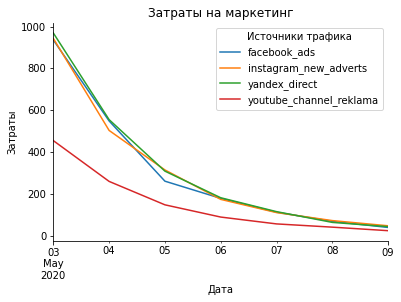

In [39]:
# Построим график
ad_costs_trend.plot()
plt.title('Затраты на маркетинг')
plt.ylabel('Затраты')
plt.xlabel('Дата')
plt.legend(title='Источники трафика')
sns.despine()
plt.show()

Пик затрат по всем источникам пришёлся на старт компании, затем затраты по всем источникам снижаются

**Количество пользователей пришедших из каждого источника трафика**

In [40]:
users = (user_source.groupby('source')
              .agg({'user_id':'nunique'})
              .rename(columns={'user_id':'users'})
              .sort_values(by='users',ascending=False)
              .round({'users': 2}))
display(users.reset_index())

,source,users
0,yandex_direct,4817
1,instagram_new_adverts,3347
2,facebook_ads,2726
3,youtube_channel_reklama,2686


In [41]:
labels_1 = [
    'yandex_direct',
    'instagram_new_adverts',
    'facebook_ads',
    'youtube_channel_reklama'
    ]
fig_ad = go.Figure(data=[go.Pie(labels=labels_1, values=users['users'])])
fig_ad.show() 

Больше всего переходов из yandex_direct, хотя instagram_new_adverts и facebook_ads отстают ненамного. Но, youtube_channel_reklama даёт сопоставимое с другими каналами число новых пользователей.

**Вывод**   
youtube_channel_reklama даёт сопоставимое с другими каналами число новых пользователей, но затраты на привлечение пользователей из этого канала существенно ниже  - возможно в этот канал выгодно инвестировать рекламный бюджет.

### Анализ влияния источника перехода в игру на поведение пользователей<a id="traffic"></a>    

In [42]:
# Добавим для каждого игрока источник трафика
game_actions_source =  game_actions.merge(user_source, how='left', on='user_id')
#game_actions_source.head() 

In [43]:
# Подсчитаем число событий (по user_id) по типам построек и источникам трафика
building_source = game_actions_source.pivot_table(
    index='source',
    columns='building_type',
    values='user_id',
    aggfunc='count')
building_source['total'] = building_source.sum(axis=1) # Подсчитаем общее количество
building_source = building_source.sort_values('total', ascending=False) # Отстортуем
display(building_source.reset_index())

building_type,source,assembly_shop,no_buildings,research_center,spaceport,total
0,yandex_direct,19295,2662,4952,20785,47694
1,instagram_new_adverts,13431,1942,3537,14847,33757
2,facebook_ads,11117,1541,2945,12069,27672
3,youtube_channel_reklama,10651,1538,2703,11624,26516


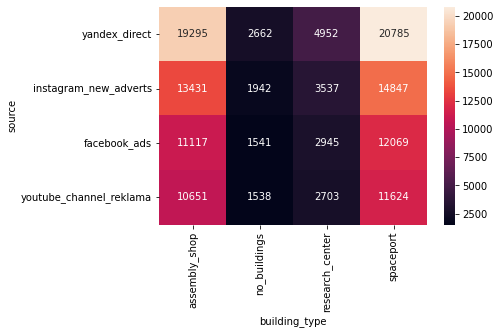

In [44]:
# Построим тепловую карту
building_source_heatmap = building_source.drop('total', axis=1) # Удалим колонку total
ax = sns.heatmap(building_source_heatmap, annot=True, fmt="d")

Вне зависомости от источника трафика игроки чаще всего строят assembly_shop и spaceport

In [45]:
# Подсчитаем число проектов (по user_id) по типам проектов и источникам трафика
project_type_source = game_actions_source.pivot_table(
    index='source',
    columns='project_type',
    values='user_id',
    aggfunc='count')
project_type_source['total'] = project_type_source.sum(axis=1) # Подсчитаем общее количество
project_type_source = project_type_source.sort_values('total', ascending=False) # Отстортуем
display(project_type_source.reset_index())

project_type,source,finished_stage_1,not_finished_stage_1,satellite_orbital_assembly,total
0,yandex_direct,2042,45032,620,47694
1,instagram_new_adverts,1466,31815,476,33757
2,facebook_ads,1150,26131,391,27672
3,youtube_channel_reklama,1159,24978,379,26516


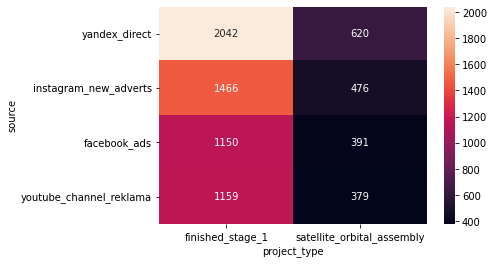

In [46]:
# Построим тепловую карту
# Удалим колонку total и колонку not_finished_stage_1 т.к. она смазывает картину
project_type_source_heatmap = project_type_source.drop(['not_finished_stage_1', 'total'], axis=1)
ax = sns.heatmap(project_type_source_heatmap, annot=True, fmt="d")

Стратегия завершения 1 уровня также не зависит от источник трафика игроков

**Выводы:**  
* Вне зависомости от источника трафика игроки чаще всего строят assembly_shop и spaceport   
* Стратегия завершения 1 уровня также не зависит от источник трафика игроков  

---

## Проверка гипотез<a id="hypotheses"></a>   


**Гипотеза 1** - Время завершения уровня различается в зависимости способа прохождения - через реализацию проекта или через победу над первым игроком.   
*Н0:* Время завершения уровня НЕ различается в зависимости от способа прохождения уровня   
*Н1:* Время завершения уровня различается в зависимости от способа прохождения уровня  

In [47]:
# Зададим  уровень статистической значимости равный 5%
alpha = 0.05 

In [48]:
# Выделим игроков завершивших 1 уровень
user_finished_stage_1 = game_actions[(game_actions['project_type'] != 'not_finished_stage_1')][['user_id', 'project_type']]
# Выделим игроков одержавших победу через реализацию проекта
user_finished_project = game_actions[game_actions['project_type'] == 'satellite_orbital_assembly'][['user_id', 'project_type']]
# Выделим игроков одержавших победу над другим игроком
user_finished_win = user_finished_stage_1[~user_finished_stage_1.isin(user_finished_project['user_id'].unique())].dropna()
# Подтянем к ним время
time_win = first_level_time[['user_id', 'hour']].merge(user_finished_win, how='left', on='user_id').dropna()
time_project = first_level_time[['user_id', 'hour']].merge(user_finished_project, how='left', on='user_id').dropna()
# Оставим только колонки со временем
time_win = time_win['hour']
time_project = time_project['hour']

In [49]:
results = st.ttest_ind(time_project, time_win)

print('p-значение:',results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу. Время завершения уровня различается в зависимости от способа прохождения уровня.")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Время завершения уровня НЕ различается в зависимости от способа прохождения уровня.")

p-значение: 7.256845329495443e-98
Отвергаем нулевую гипотезу. Время завершения уровня различается в зависимости от способа прохождения уровня.


In [50]:
# Посмотрим на сколько время завершения 1 отличается
print('Среднее время прохождения уровня - победа над другим игроком:', round(time_win.mean(), 2), 'часов')
print('Среднее время прохождения уровня - реализация проекта:', round(time_project.mean(), 2), 'часов')
print('Разница:', round(time_project.mean() - time_win.mean(), 2), 'часов')

Среднее время прохождения уровня - победа над другим игроком: 266.51 часов
Среднее время прохождения уровня - реализация проекта: 323.01 часов
Разница: 56.51 часов


Распределение времени прохождения для игроков реализовавших проект


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



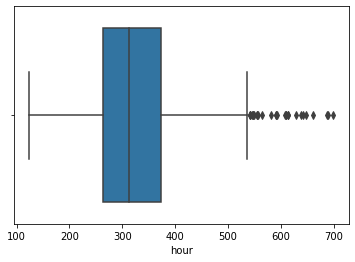

In [51]:
sns.boxplot(time_project)
print('Распределение времени прохождения для игроков реализовавших проект')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Распределение времени прохождения для игроков победивших другого игрока


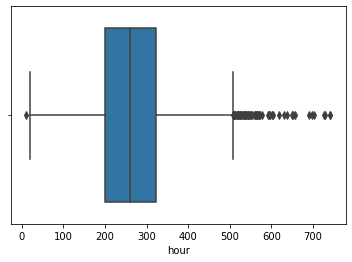

In [52]:
sns.boxplot(time_win)
print('Распределение времени прохождения для игроков победивших другого игрока')

**Вывод**   
Время завершения уровня различается в зависимости от способа прохождения уровня - игроки реализующие проект, в середнем заканчивают 1 уровень на 56 с половиной часов раньше чем игроки, одерживающие победу над другими игроками.

**Гипотеза 2** - Способ прохождения уровня - через реализацию проекта или через победу над первым игроком -  не зависит от источника трафика, из которого пришёл игрок.   
*H0:* Способ прохождения уровня не зависит от источника трафика   
*H1:* Способ прохождения уровня зависит от источника трафика 

In [53]:
# Подтянем к игрокам источники из которых они пришли
user_finished_win = user_finished_win.merge(user_source, how='left', on='user_id').dropna()
user_finished_project = user_finished_project.merge(user_source, how='left', on='user_id').dropna()

In [54]:
# Стандартизируем исходы того,  как пользователь завершил 1 уровень:
# 1 - Игрок завершил уровень победой над первым врагом
# 0 - Игрок завершил уровень выполнением проекта
# Запишем в новую колонку id_finish
user_finished_win['id_finish'] = 1 # Игрок завершил уровень победой над первым врагом
user_finished_project['id_finish'] = 0 # Игрок завершил уровень выполнением проекта
finished = pd.concat([user_finished_win, user_finished_project]) # Объеденим всех пользователей завершивших 1 уровень
#finished

In [55]:
# Разделим записи по источникам и оставим только то, как был завершён 1 уровень 
instagram = finished[finished['source'] == 'instagram_new_adverts']['id_finish']
facebook = finished[finished['source'] == 'facebook_ads']['id_finish']
youtube = finished[finished['source'] == 'youtube_channel_reklama']['id_finish']
yandex = finished[finished['source'] == 'yandex_direct']['id_finish']

In [56]:
# У нас будет 6 проверок гипотезы - мы сравним каждый канал с каждым 
# Поэтому для проверки гипотезы воспользуемся критерием Уилкоксона-Манна-Уитни
alpha_2 = 0.05 / 6

# Напишем функцию для проверок гипотезы
def stat(H0, H1, title):# Забираем сравниваемые выборки и заголовки сравнений
    print('\033[1m' + title + '\033[0m' + '\n') 

    results = st.mannwhitneyu(H0, H1) # Расчёт теста Уилкоксона-Манна-Уитни

    print('p-значение: ', results.pvalue) # Расчёт p-value

    if results.pvalue < alpha_2: # Сравнение p-value с альфа
        print('Отвергаем нулевую гипотезу')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу'
        )
    
    print('\n')

In [57]:
# Проверим гипотезу
stat(instagram, facebook, 'instagram_new_adverts/facebook_ads')
stat(instagram, youtube, 'instagram_new_adverts/youtube_channel_reklama')
stat(instagram, yandex, 'instagram_new_adverts/yandex_direct')
stat(facebook, youtube, 'facebook_ads/youtube_channel_reklama')
stat(facebook, yandex, 'facebook_ads/yandex_direct')
stat(youtube, yandex, 'youtube_channel_reklama/yandex_direct')

instagram_new_adverts/facebook_ads

p-значение:  0.40919319567631285
Не получилось отвергнуть нулевую гипотезу


instagram_new_adverts/youtube_channel_reklama

p-значение:  0.9001181567908461
Не получилось отвергнуть нулевую гипотезу


instagram_new_adverts/yandex_direct

p-значение:  0.18426828022587327
Не получилось отвергнуть нулевую гипотезу


facebook_ads/youtube_channel_reklama

p-значение:  0.5079689382321106
Не получилось отвергнуть нулевую гипотезу


facebook_ads/yandex_direct

p-значение:  0.033959962425478496
Не получилось отвергнуть нулевую гипотезу


youtube_channel_reklama/yandex_direct

p-значение:  0.17008753269777588
Не получилось отвергнуть нулевую гипотезу




**Вывод**  
Способ прохождения уровня не зависит от источника трафика - неважно из какого канала трафика пришли игроки, играют они одинаково.    
На выбор одной из двух стратегий завершения первого уровня влияют другие фактоы - скорее всего социально-культурные (так пользователи из США могут больше ориетироваться на победу над другими игроками, а из Японии - на реализацию проектов, и это будет обусловлено их культурой - победы или созидания) и личностные (терпеливость, азарт и т.д.).

---

## Выводы и рекомендации<a id="summary"></a>   
### Выводы:  
Мы обработали пропуски, удалили дубликат и исправили типы данных в датафремах. Исследовательский анализ данных (EDA) явных аномалий в датафремах не выявил.   
     
**Анализ активности игроков показал:**
* Количество уникальных пользователей за весь период 13 576 человек   
* Количество событий за весь период 135 639 единиц   
* Самое распространённое событие - строительство объекта   
* Наиболее популярный тип объекта - spaceport  
* Большинство игроков построили 6, 10 или 12 объектов   
* За всё время 1 уровень завершили 5817 игроков (56.6 % игроков)   
* Победой над первым врагом уровень завершили 5817 игроков (42.8 % игроков)   
* Выполнением проекта уровень завершили 1866 игроков (13.7 % игроков)   
* Минимальное время прохождения 1 уровня: 9 часов 39 минут   
* Максимальное время прохождения 1 уровня:  30 дней 21 час 58 минут  
* Среднее время прохождения 1 уровня: 11 дней 20 часов 8 минут   
* Медианное время прохождения 1 уровня: 11 дней 13 часов 28 минут   
    
**Анализ рекламной активности показал:**   
* Больше всего затрат на yandex_direct, хотя instagram_new_adverts и facebook_ads отстают ненамного.    
* Но, больше всего пользователей пришло из yandex_direct. Наибольшая стоимость 1 перехода у facebook_ads, наименьшая - youtube_channel_reklama.   
* При относительно небольшой стоимости привлечения клиента и самым большим количеством привлеченых пользователей выгодно выделяется yandex_direct.   
* Пик затрат по всем источникам пришёлся на старт компании, затем затраты по всем источникам снижаются.   
* Больше всего переходов из yandex_direct, хотя instagram_new_adverts и facebook_ads отстают ненамного. Но, youtube_channel_reklama даёт сопоставимое с другими каналами число новых пользователей.    
* youtube_channel_reklama даёт сопоставимое с другими каналами число новых пользователей, но затраты на привлечение пользователей из этого канала существенно ниже - возможно в этот канал выгодно инвестировать рекламный бюджет.   
   
**Анализ влияния источника перехода в игру на поведение пользователей показал:**       
* Вне зависимости от источника трафика игроки чаще всего строят assembly_shop и spaceport.   
* Стратегия завершения 1 уровня также не зависит от источник трафика игроков.  
   
**Было проверено две гипотезы:**  
 
**Проверка гипотезы 1** - *Время завершения уровня различается в зависимости способа прохождения - через реализацию проекта или через победу над первым игроком*, показала, что:  
* Время завершения уровня различается в зависимости от способа прохождения уровня.   
* Игроки реализующие проект, в середнем заканчивают 1 уровень на 56 с половиной часов раньше чем игроки, одерживающие победу над другими игроками.   

**Проверка гипотезы 2** - *Способ прохождения уровня - через реализацию проекта или через победу над первым игроком - не зависит от источника трафика, из которого пришёл игрок*, показала, что:   
* Способ прохождения уровня не зависит от источника трафика - неважно из какого канала трафика пришли игроки, играют они одинаково.   
* Верояно, на выбор одной из двух стратегий завершения первого уровня влияют другие факторы - скорее всего социально-культурные (так пользователи из США могут больше ориетироваться на победу над другими игроками, а из Японии - на реализацию проектов, и это будет обусловлено их культурой - победы или созидания) и личностные (терпеливость, азарт и т.д.).     


### Рекомендации: 
* Все источники интересны с точки зрения привлечени игроков, но рекламные бюджеты можно сконцентрировать на youtube_channel_reklama и yandex_direct.   
* Время прохождения первого уровня  долгое даже у самого быстрого игрока - игроки могут терять интерес и бросать игру. Возможно первыый уровень можно разбить на несколько. Экран перехода с уровня на уровень/ загрузки нового уровня, использовать для рекламы
* Также можно дабавить промежучтоные уровни объектов, по типу уровня построек в "Героях меча и магии". Данные улучшение увеличат посещаемость окна постройки объекта  и соответственно показы рекламы в данном окне.

In [58]:
# И в конце - пасхалка. Для запуска раскомментируй и запусти код ниже.
# И в конце пасхалка, как в компьтерной игре
# Раскомметируй и запусти код ниже
from IPython.display import Image
display(Image(url='https://i.gifer.com/5UKF.gif', width = 200))